<img src='../img/joint_school_banner_2.png' alt='Training school and workshop on fire' align='center' width='100%'></img>

<br>

<hr>

# MODIS Fire Radiative Power

### About

This notebook provides you an introduction to data from the <a href='https://modis.gsfc.nasa.gov/about/' target='_blank'>Moderate Resolution Imaging Spectroradiometer (MODIS)</a>. We are using MODIS fire radiative power data as a proxy for the next-generation <a href='https://landsaf.ipma.pt/en/products/fire-products/frppixel/' target='_blank'>Fire Radiative Power Pixel (FRPPIXEL) product</a> from LSA SAF that will integrate data from Meteosat Third Generation's <a href='https://www.eumetsat.int/mtg-flexible-combined-imager' target='_blank'>Flexible Combined Imager</a>.

This notebook shows the structure of <a href='https://earthdata.nasa.gov/earth-observation-data/near-real-time/firms/mcd14dl' target='_blank'>MODIS Thermal Anomalies/Fire locations 1km FIRMS V0061 NRT (Vector data)</a> and how to load, browse and visualise the data. 

The events featured in this notebook are the wildfires in Italy and Greece in summer 2021. 

### Basic Facts

> **Spatial coverage**: `Global` <br>
> **Time step**: `Monthly` <br>
> **Data availability**: `since 2000`


### How to access the data

This notebook uses the MODIS MCD14DL dataset from the Terra and Aqua platforms. The MCD14DL dataset archive can be ordered via the <a href='https://firms.modaps.eosdis.nasa.gov/download/' target='_blank'>FIRMS</a> and are distributed in `shp`, `json` or `csv` format, which is then zipped. 

You need to <a href='https://urs.earthdata.nasa.gov/' target='_blank'>register for an Earthdata account</a> before being able to download data.

<hr>

##### Load required libraries

In [9]:
import os
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors
from matplotlib.colors import BoundaryNorm, ListedColormap
import ipynb

from netCDF4 import Dataset
import pandas as pd
import glob

import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

from matplotlib.axes import Axes
from cartopy.mpl.geoaxes import GeoAxes
GeoAxes._pcolormesh_patched = Axes.pcolormesh

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action = "ignore", category = RuntimeWarning)

##### Load helper functions

In [10]:
%run ../functions.ipynb

<hr>

## <a id="modis_load"></a>1. Load and browse MODIS Fire Radiative Power data

[OPTIONAL] The first step is to unzip files from the zipped archive downloaded. The zipped archive contains data in a Comma-Separated Values or `csv` file and a Readme text document. The period requested was from 5 August 2021 to 7 August 2021. 
This step is optional as we have already unzipped the file for you. This is why the code is commented out.

In [11]:
# import zipfile
# with zipfile.ZipFile('../../../eodata/lps_fire/modis/level2/frp/DL_FIRE_M-C61_251212.zip', 'r') as zip_ref:
#    zip_ref.extractall('../../../eodata/lps_fire/modis/level2/frp/2021/08')

After we downloaded the station observations as a `csv` file, we can open it with the pandas function `read_table()`. We additonally set specific keyword arguments that allow us to specify the columns and rows of interest:
* `delimiter`: specify the delimiter in the text file, e.g. comma
* `header`: specify the index of the row that shall be set as header.
* `index_col`: specify the index of the column that shall be set as index

You see below that the resulting dataframe has 2108 rows and 14 columns.

In [12]:
df = pd.read_table('../../../eodata/lps_fire/modis/level2/frp/2021/08/fire_archive_M-C61_251212.csv', delimiter=',', header=[0], index_col=5)
df

latitude  longitude  brightness  scan  track  acq_time satellite  \
acq_date                                                                       
2021-08-05   44.1170    25.1176       311.1   1.0    1.0        26      Aqua   
2021-08-05   42.0245    20.2539       300.0   1.3    1.1        26      Aqua   
2021-08-05   42.0330    20.2704       308.4   1.3    1.1        26      Aqua   
2021-08-05   42.0345    20.2566       353.5   1.3    1.1        26      Aqua   
2021-08-05   42.0362    20.2410       325.0   1.3    1.1        26      Aqua   
...              ...        ...         ...   ...    ...       ...       ...   
2021-08-07   44.7821    20.5855       326.8   1.1    1.1      2043     Terra   
2021-08-07   44.7837    20.5996       362.9   1.1    1.1      2043     Terra   
2021-08-07   43.2199    12.6086       306.7   1.5    1.2      2043     Terra   
2021-08-07   37.0451    28.8563       302.3   3.6    1.8      2320      Aqua   
2021-08-07   37.0504    28.8543       308.4   3.6    1.8      2320      Aqua   

           instrument  confidence  version  bright_t31    frp daynight  type  
acq_date                                                                      
2021-08-05      MODIS          82     6.03       287.8   11.6        N     0  
2021-08-05      MODIS           2     6.03       289.6    4.4        N     0  
2021-08-05      MODIS          74     6.03       291.1   11.4        N     0  
2021-08-05      MODIS         100     6.03       295.1  101.7        N     0  
2021-08-05      MODIS         100     6.03       291.2   32.3        N     0  
...               ...         ...      ...         ...    ...      ...   ...  
2021-08-07      MODIS         100     6.03       292.9   29.1        N     0  
2021-08-07      MODIS         100     6.03       297.5  110.4        N     0  
2021-08-07      MODIS          69     6.03       293.5   10.7        N     0  
2021-08-07      MODIS          38     6.03       290.5   32.9        N     0  
2021-08-07      MODIS          74     6.03       290.3   56.2        N     0  

[2108 rows x 14 columns]

From the dataframe above, let us only select the columns of interest for us. This makes the handling of the dataframe much easier. The columns of interest are: `acq_date`, `latitude`, `longitude`, `confidence` and `frp`. You can use the function `filter()` to select specific columns.

In [13]:
frp = df.filter(['acq_date','latitude','longitude','confidence','frp'])
frp

latitude  longitude  confidence    frp
acq_date                                          
2021-08-05   44.1170    25.1176          82   11.6
2021-08-05   42.0245    20.2539           2    4.4
2021-08-05   42.0330    20.2704          74   11.4
2021-08-05   42.0345    20.2566         100  101.7
2021-08-05   42.0362    20.2410         100   32.3
...              ...        ...         ...    ...
2021-08-07   44.7821    20.5855         100   29.1
2021-08-07   44.7837    20.5996         100  110.4
2021-08-07   43.2199    12.6086          69   10.7
2021-08-07   37.0451    28.8563          38   32.9
2021-08-07   37.0504    28.8543          74   56.2

[2108 rows x 4 columns]

Next, we filter the dataframe for rows which have an acquisition date or `acq_date` of `2021-08-05`. You will see that the number of rows is reduced to 785 rows.

In [14]:
frp = frp.filter(like='2021-08-05', axis=0)
frp

latitude  longitude  confidence    frp
acq_date                                          
2021-08-05   44.1170    25.1176          82   11.6
2021-08-05   42.0245    20.2539           2    4.4
2021-08-05   42.0330    20.2704          74   11.4
2021-08-05   42.0345    20.2566         100  101.7
2021-08-05   42.0362    20.2410         100   32.3
...              ...        ...         ...    ...
2021-08-05   37.3375    28.3422          87   38.7
2021-08-05   37.3261    28.3095         100   73.4
2021-08-05   37.3241    28.3384          79   33.2
2021-08-05   37.0630    31.4832          52    8.7
2021-08-05   37.3310    28.3050         100   93.0

[785 rows x 4 columns]

Next, we remove the rows which have a confidence level below 60 percent. 

In [15]:
frp = frp[frp['confidence'] >= 60]
frp

latitude  longitude  confidence    frp
acq_date                                          
2021-08-05   44.1170    25.1176          82   11.6
2021-08-05   42.0330    20.2704          74   11.4
2021-08-05   42.0345    20.2566         100  101.7
2021-08-05   42.0362    20.2410         100   32.3
2021-08-05   41.8277    22.7949          79   16.6
...              ...        ...         ...    ...
2021-08-05   37.3396    28.3121         100   74.8
2021-08-05   37.3375    28.3422          87   38.7
2021-08-05   37.3261    28.3095         100   73.4
2021-08-05   37.3241    28.3384          79   33.2
2021-08-05   37.3310    28.3050         100   93.0

[650 rows x 4 columns]

## <a id="modis_load"></a>2. Visualise MODIS MCD14DL Level 2 data

You can make use of the `ListedColorMap` function from the matplotlib library to define the colors for each fire radiative power (FRP) class.

In [16]:
frp_cm = ListedColormap([[0, 0, 255./255.],
                                 [176./255., 196./255., 222./255.],
                                 [255./255., 255./255., 0],
                                 [1., 140./255., 0],
                                 [178./255., 34./255., 34./255.],
                                 [1, 0, 0]])

You can define the levels for the respective FRP classes in a list stored in the variable `bounds`. You can also use the `.BoundaryNorm()` function from `matplotlib.colors` to define the norm that you will use for plotting later. 

In [17]:
bounds = [0, 30, 40, 60, 80, 120, 500]
norm = BoundaryNorm(bounds, frp_cm.N)

<br>

The last step is to visualise the `FRP` data with matplotlib's `scatter` function.

The plotting code can be divided in five main parts:
* **Initiate a matplotlib figure**: Initiate a matplotlib plot and define the size of the plot
* **Specify coastlines, borders and a grid**: specify additional features to be added to the plot
* **Plotting function**: plot the data with the plotting function `scatter`
* **Specify color bar**: specify the color bar properties
* **Set plot title**: specify title of the plot

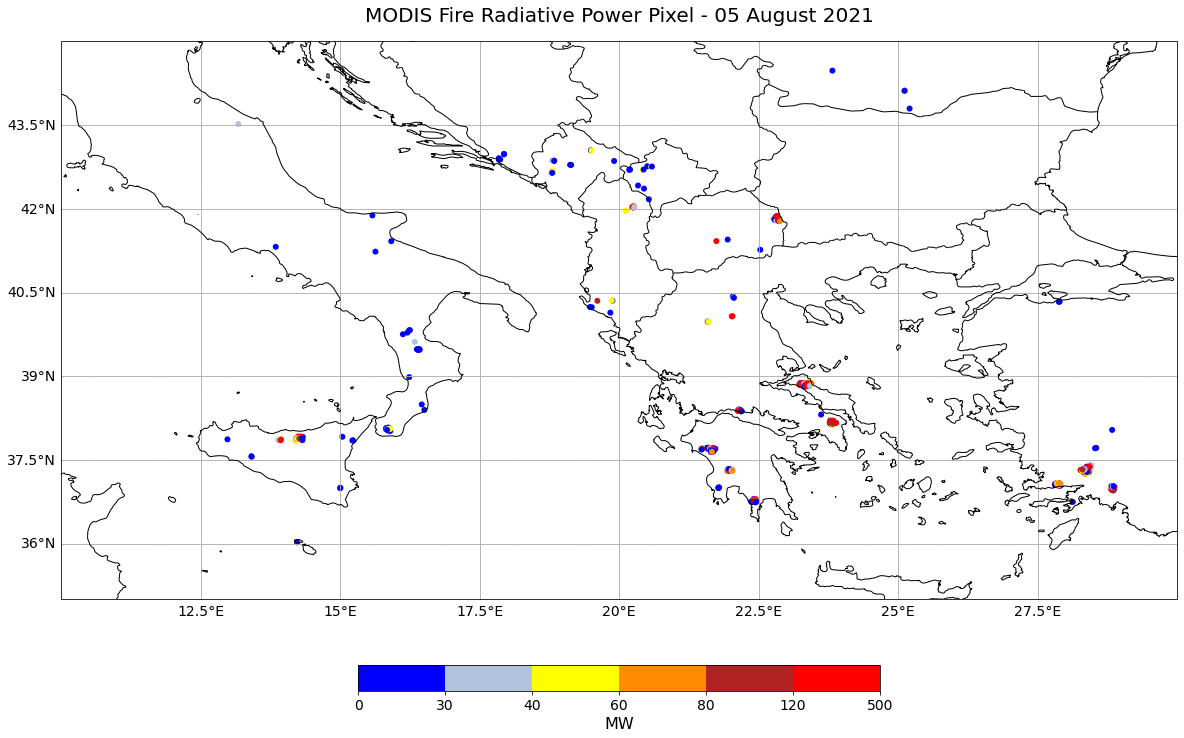

In [18]:
# Initiate a matplotlib figure
fig=plt.figure(figsize=(20, 12))
ax=plt.axes(projection=ccrs.PlateCarree())

# Specify coastlines and borders
ax.coastlines(zorder=3)
ax.add_feature(cfeature.BORDERS, edgecolor='black', linewidth=1, zorder=3)

# Specify a grid
gl = ax.gridlines()
gl = ax.gridlines(draw_labels=True, linestyle='--')
gl.top_labels=False
gl.right_labels=False
gl.xformatter=LONGITUDE_FORMATTER
gl.yformatter=LATITUDE_FORMATTER
gl.xlabel_style={'size':14}
gl.ylabel_style={'size':14}

# Set the plot extent
ax.set_extent([10, 30, 35, 45], ccrs.PlateCarree())

# Plotting function
img1 = plt.scatter(frp['longitude'],frp['latitude'], c=frp['frp'],
                   edgecolors='none',
                   cmap=frp_cm,
                   norm=norm,
                   zorder=2)


# Specify colorbar 
cbar = fig.colorbar(img1, ax=ax, orientation='horizontal', fraction=0.04, pad=0.1)
cbar.set_label('MW',fontsize=16)
cbar.ax.tick_params(labelsize=14)

# Set plot title
ax.set_title('MODIS Fire Radiative Power Pixel - 05 August 2021', fontsize=20, pad=20.0)

# Show plot
plt.show()

**Return to the chapter:**
- [Atmospheric impacts of wildfires](./01_atmosphere_intro.ipynb#modis_frp)

<hr>

<p style="text-align:right;">This project is licensed under the <a href="./LICENSE">MIT License</a> and is developed under a Copernicus contract.